# TF-IDF


In [4]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import spacy
from tqdm import tqdm  # Import tqdm

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv(r'E:\SNU Chennai\projects\NLP project\NEWS classification\news article\news-article-categories.csv')

# Combine 'title' and 'body' columns into a single 'text' column
df['text'] = df['title'] + " " + df['body']

# Drop rows where 'text' is missing
df = df.dropna(subset=['text'])

# Preprocessing function using spaCy
def preprocess_text(text):
    # Process text with spaCy
    doc = nlp(text.lower())
    
    # Remove stopwords and non-alphabetic tokens, then lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    # Join back into a string
    return " ".join(tokens)

# Apply preprocessing to the 'text' column with tqdm
print("Preprocessing text...")
tqdm.pandas()  # Enable tqdm progress_apply
df['clean_text'] = df['text'].progress_apply(preprocess_text)  # Use progress_apply instead of apply

# Split the dataset into 80% training and 20% testing
# Keep the 'clean_text' column in both train and test sets
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['category']
)

# Separate features and labels for training and testing
X_train = train_df['clean_text']
X_test = test_df['clean_text']
y_train = train_df['category']
y_test = test_df['category']

# Count the number of news articles in each category
train_category_counts = Counter(y_train)
test_category_counts = Counter(y_test)

print("\nTraining Set Category Distribution:")
for category, count in train_category_counts.items():
    print(f"{category}: {count}")

print("\nTest Set Category Distribution:")
for category, count in test_category_counts.items():
    print(f"{category}: {count}")


Preprocessing text...


100%|██████████| 6872/6872 [06:47<00:00, 16.86it/s]


Training Set Category Distribution:
TECH: 400
COMEDY: 301
CRIME: 240
ARTS & CULTURE: 800
ENTERTAINMENT: 401
ENVIRONMENT: 401
EDUCATION: 392
POLITICS: 401
BUSINESS: 401
WOMEN: 401
MEDIA: 277
RELIGION: 401
SPORTS: 401
SCIENCE: 280

Test Set Category Distribution:
EDUCATION: 98
COMEDY: 75
SPORTS: 100
ENVIRONMENT: 100
RELIGION: 100
ARTS & CULTURE: 201
ENTERTAINMENT: 100
BUSINESS: 100
POLITICS: 100
TECH: 101
SCIENCE: 70
MEDIA: 70
WOMEN: 100
CRIME: 60


In [11]:

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data with tqdm
print("Vectorizing training data...")
X_train_tfidf = vectorizer.fit_transform(tqdm(X_train))

# Transform the test data with tqdm
print("Vectorizing test data...")
X_test_tfidf = vectorizer.transform(tqdm(X_test))

# Print TF-IDF matrix shapes
print("\nTraining TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)



Vectorizing training data...


100%|██████████| 5497/5497 [00:03<00:00, 1659.00it/s]


Vectorizing test data...


100%|██████████| 1375/1375 [00:00<00:00, 2776.67it/s]


Training TF-IDF shape: (5497, 5000)
Test TF-IDF shape: (1375, 5000)


In [12]:
# Train a Logistic Regression model
print("Training Logistic Regression model...")
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)  # No tqdm here because X_train_tfidf is a sparse matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_tfidf)  # No tqdm here because X_test_tfidf is a sparse matrix

# Evaluate performance
print("\nAccuracy with TF-IDF:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training Logistic Regression model...
Making predictions...

Accuracy with TF-IDF: 0.8

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.80      0.90      0.84       201
      BUSINESS       0.72      0.70      0.71       100
        COMEDY       0.78      0.68      0.73        75
         CRIME       0.81      0.80      0.81        60
     EDUCATION       0.83      0.83      0.83        98
 ENTERTAINMENT       0.77      0.83      0.80       100
   ENVIRONMENT       0.81      0.87      0.84       100
         MEDIA       0.81      0.69      0.74        70
      POLITICS       0.74      0.83      0.78       100
      RELIGION       0.89      0.88      0.88       100
       SCIENCE       0.88      0.83      0.85        70
        SPORTS       0.89      0.85      0.87       100
          TECH       0.80      0.76      0.78       101
         WOMEN       0.69      0.61      0.65       100

      accuracy                           0.80 

100%|██████████| 1375/1375 [00:00<00:00, 116990.59it/s]


Misclassifications:
Example 1:
  Raw Input: Asia Argento's Fiery Speech Closes Cannes: ‘I Was Raped By Harvey Weinstein Here’ There were a few moments of protest for equal rights at the Cannes Film Festival this year, but none quite as fierce as the surprise speech actress Asia Argento gave at the festival’s closing ceremony on Saturday. Before presenting the award for best actress, Argento said she had something to say. She called Cannes Harvey Weinstein’s “hunting ground,” and said he raped her at the festival in 1997 when she was 21 years old. Festival organizers reportedly had no idea she was going to make any remarks. “I want to make a prediction,” she added. “Harvey Weinstein will never be welcomed here ever again. He will live in disgrace shunned by a film community that once embraced him and covered up for his crimes.” She went on to call out predators she said still work in the film industry and issued a warning. “And even tonight sitting among you there are those who still h

In [13]:
from sklearn.svm import LinearSVC  # Import LinearSVC for SVM


# Train an SVM model (LinearSVC)
print("Training SVM model...")
clf = LinearSVC(max_iter=1000)  # Use LinearSVC for linear kernel SVM
clf.fit(X_train_tfidf, y_train)  # No tqdm here because X_train_tfidf is a sparse matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_tfidf)  # No tqdm here because X_test_tfidf is a sparse matrix

# Evaluate performance
print("\nAccuracy with TF-IDF:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training SVM model...
Making predictions...

Accuracy with TF-IDF: 0.8123636363636364

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.87      0.90      0.88       201
      BUSINESS       0.72      0.72      0.72       100
        COMEDY       0.76      0.69      0.73        75
         CRIME       0.79      0.87      0.83        60
     EDUCATION       0.84      0.86      0.85        98
 ENTERTAINMENT       0.81      0.79      0.80       100
   ENVIRONMENT       0.81      0.83      0.82       100
         MEDIA       0.80      0.76      0.78        70
      POLITICS       0.77      0.82      0.80       100
      RELIGION       0.88      0.91      0.89       100
       SCIENCE       0.83      0.84      0.84        70
        SPORTS       0.90      0.86      0.88       100
          TECH       0.81      0.78      0.79       101
         WOMEN       0.71      0.65      0.68       100

      accuracy                           0.81  

100%|██████████| 1375/1375 [00:00<00:00, 116191.56it/s]


Misclassifications:
Example 1:
  Raw Input: Asia Argento's Fiery Speech Closes Cannes: ‘I Was Raped By Harvey Weinstein Here’ There were a few moments of protest for equal rights at the Cannes Film Festival this year, but none quite as fierce as the surprise speech actress Asia Argento gave at the festival’s closing ceremony on Saturday. Before presenting the award for best actress, Argento said she had something to say. She called Cannes Harvey Weinstein’s “hunting ground,” and said he raped her at the festival in 1997 when she was 21 years old. Festival organizers reportedly had no idea she was going to make any remarks. “I want to make a prediction,” she added. “Harvey Weinstein will never be welcomed here ever again. He will live in disgrace shunned by a film community that once embraced him and covered up for his crimes.” She went on to call out predators she said still work in the film industry and issued a warning. “And even tonight sitting among you there are those who still h

# Word2Vec

In [14]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import spacy
from tqdm import tqdm  # Import tqdm
import gensim.downloader as api  # To load pre-trained Word2Vec model
import numpy as np


# Load pre-trained Word2Vec model
print("Loading pre-trained Word2Vec model...")
word2vec_model = api.load("word2vec-google-news-300")  # Google's pre-trained Word2Vec model

# Function to compute document vectors using Word2Vec
def get_document_vector(text, model, size=300):
    # Tokenize the text
    tokens = text.split()
    
    # Get word vectors for tokens present in the Word2Vec model
    vectors = [model[word] for word in tokens if word in model]
    
    # If no valid words are found, return a zero vector
    if len(vectors) == 0:
        return np.zeros(size)
    
    # Compute the average vector
    return np.mean(vectors, axis=0)

# Convert documents to Word2Vec vectors
print("Converting training data to Word2Vec vectors...")
X_train_vectors = np.array([get_document_vector(text, word2vec_model) for text in tqdm(X_train)])

print("Converting test data to Word2Vec vectors...")
X_test_vectors = np.array([get_document_vector(text, word2vec_model) for text in tqdm(X_test)])

# Print vector shapes
print("\nTraining Word2Vec shape:", X_train_vectors.shape)
print("Test Word2Vec shape:", X_test_vectors.shape)



Loading pre-trained Word2Vec model...
Converting training data to Word2Vec vectors...


100%|██████████| 5497/5497 [00:02<00:00, 2005.83it/s]


Converting test data to Word2Vec vectors...


100%|██████████| 1375/1375 [00:00<00:00, 2291.20it/s]


Training Word2Vec shape: (5497, 300)
Test Word2Vec shape: (1375, 300)


In [15]:
# Train a Logistic Regression model
print("Training Logistic Regression model...")
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with Word2Vec:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training Logistic Regression model...
Making predictions...

Accuracy with Word2Vec: 0.7396363636363636

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.73      0.86      0.79       201
      BUSINESS       0.63      0.62      0.63       100
        COMEDY       0.62      0.53      0.58        75
         CRIME       0.74      0.83      0.78        60
     EDUCATION       0.79      0.79      0.79        98
 ENTERTAINMENT       0.66      0.67      0.66       100
   ENVIRONMENT       0.80      0.84      0.82       100
         MEDIA       0.67      0.51      0.58        70
      POLITICS       0.72      0.70      0.71       100
      RELIGION       0.83      0.88      0.85       100
       SCIENCE       0.85      0.83      0.84        70
        SPORTS       0.87      0.82      0.85       100
          TECH       0.75      0.67      0.71       101
         WOMEN       0.66      0.62      0.64       100

      accuracy               

100%|██████████| 1375/1375 [00:00<00:00, 133502.35it/s]


Misclassifications:
Example 1:
  Raw Input: Adrian Lester: Best Robert in Stephen Sondheim's 'Company' Phone rings, door chimes, in comes Stephen Sondheim's Company! Please let me know in the comments your favorite Bobby.  I appreciate everyone's sincere feedback so far. I encourage you to please engage in this discussion. I am watching the Sam Mendes production right now and Amy is about to not get married! This song can make or break my critique. Did you know it's even faster than Guns and Ships from Hamilton? Jon said  "Raul's Bobby was robbed of the Tony. I saw it in Cincinnati and on Broadway and it was just devastating. I've seen the tape of the original cast recording and the national tour that was one of the first in the library at Lincoln Center. I didn't like the Ken Cen version much; the book scenes worked but the musical choreography was weak. NPH and the recent cast were strong, but my favorite as a whole is Sam Mendes production starring Adrian Lester, whose .... fueled 

In [16]:
# Train an SVM model
print("Training SVM model...")
from sklearn.svm import LinearSVC  # Import LinearSVC for SVM
clf = LinearSVC(max_iter=1000)  # Use LinearSVC for linear kernel SVM
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with Word2Vec:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training SVM model...
Making predictions...

Accuracy with Word2Vec: 0.76

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.81      0.87      0.83       201
      BUSINESS       0.70      0.65      0.67       100
        COMEDY       0.66      0.53      0.59        75
         CRIME       0.72      0.82      0.77        60
     EDUCATION       0.78      0.85      0.81        98
 ENTERTAINMENT       0.73      0.69      0.71       100
   ENVIRONMENT       0.78      0.85      0.81       100
         MEDIA       0.64      0.51      0.57        70
      POLITICS       0.74      0.69      0.72       100
      RELIGION       0.83      0.91      0.87       100
       SCIENCE       0.80      0.86      0.83        70
        SPORTS       0.85      0.88      0.87       100
          TECH       0.76      0.70      0.73       101
         WOMEN       0.67      0.65      0.66       100

      accuracy                           0.76      1375
   

100%|██████████| 1375/1375 [00:00<00:00, 177680.94it/s]


Misclassifications:
Example 1:
  Raw Input: Asia Argento's Fiery Speech Closes Cannes: ‘I Was Raped By Harvey Weinstein Here’ There were a few moments of protest for equal rights at the Cannes Film Festival this year, but none quite as fierce as the surprise speech actress Asia Argento gave at the festival’s closing ceremony on Saturday. Before presenting the award for best actress, Argento said she had something to say. She called Cannes Harvey Weinstein’s “hunting ground,” and said he raped her at the festival in 1997 when she was 21 years old. Festival organizers reportedly had no idea she was going to make any remarks. “I want to make a prediction,” she added. “Harvey Weinstein will never be welcomed here ever again. He will live in disgrace shunned by a film community that once embraced him and covered up for his crimes.” She went on to call out predators she said still work in the film industry and issued a warning. “And even tonight sitting among you there are those who still h

# GloVe

In [5]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import spacy
from tqdm import tqdm  # Import tqdm
import numpy as np


# Load pre-trained GloVe embeddings
print("Loading pre-trained GloVe embeddings...")
glove_path = r"E:\SNU Chennai\projects\NLP project\IEEE Research Papers Topic Modelling\glove.6B\glove.6B.300d.txt"  # Path to GloVe file (download from https://nlp.stanford.edu/projects/glove/)
embedding_dim = 300  # Dimension of GloVe vectors

# Create a dictionary to store GloVe word vectors
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Loading GloVe"):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Function to compute document vectors using GloVe
def get_document_vector(text, embeddings, size=300):
    # Tokenize the text
    tokens = text.split()
    
    # Get word vectors for tokens present in the GloVe embeddings
    vectors = [embeddings[word] for word in tokens if word in embeddings]
    
    # If no valid words are found, return a zero vector
    if len(vectors) == 0:
        return np.zeros(size)
    
    # Compute the average vector
    return np.mean(vectors, axis=0)

# Convert documents to GloVe vectors
print("Converting training data to GloVe vectors...")
X_train_vectors = np.array([get_document_vector(text, glove_embeddings) for text in tqdm(X_train)])

print("Converting test data to GloVe vectors...")
X_test_vectors = np.array([get_document_vector(text, glove_embeddings) for text in tqdm(X_test)])

# Print vector shapes
print("\nTraining GloVe shape:", X_train_vectors.shape)
print("Test GloVe shape:", X_test_vectors.shape)



Loading pre-trained GloVe embeddings...


Loading GloVe: 400000it [00:13, 28801.16it/s]


Converting training data to GloVe vectors...


100%|██████████| 5497/5497 [00:01<00:00, 4404.67it/s]


Converting test data to GloVe vectors...


100%|██████████| 1375/1375 [00:00<00:00, 4877.01it/s]


Training GloVe shape: (5497, 300)
Test GloVe shape: (1375, 300)


In [6]:
# Train a Logistic Regression model
print("Training Logistic Regression model...")
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with GloVe:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training Logistic Regression model...
Making predictions...

Accuracy with GloVe: 0.757090909090909

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.80      0.87      0.83       201
      BUSINESS       0.67      0.64      0.65       100
        COMEDY       0.65      0.57      0.61        75
         CRIME       0.73      0.82      0.77        60
     EDUCATION       0.76      0.80      0.78        98
 ENTERTAINMENT       0.66      0.67      0.66       100
   ENVIRONMENT       0.78      0.83      0.81       100
         MEDIA       0.68      0.54      0.60        70
      POLITICS       0.75      0.75      0.75       100
      RELIGION       0.86      0.89      0.87       100
       SCIENCE       0.83      0.84      0.84        70
        SPORTS       0.89      0.85      0.87       100
          TECH       0.74      0.72      0.73       101
         WOMEN       0.67      0.64      0.66       100

      accuracy                   

100%|██████████| 1375/1375 [00:00<00:00, 98348.70it/s]


Misclassifications:
Example 1:
  Raw Input: You'll 'Like' This Bad Lip Reading Of Mark Zuckerberg's Congressional Hearing Bad Lip Reading’s new spoof video reveals what really went down during Facebook CEO Mark Zuckerberg’s hearing before Congress. Zuckerberg was grilled by the House Energy and Commerce Committee earlier this month over the social media platform’s role in the Cambridge Analytica data scandal. On Tuesday, the YouTube channel released its own amusing interpretation of events:  Check out the full clip above.
  Predicted: TECH
  Correct: COMEDY
--------------------------------------------------------------------------------
Example 2:
  Raw Input: Asia Argento's Fiery Speech Closes Cannes: ‘I Was Raped By Harvey Weinstein Here’ There were a few moments of protest for equal rights at the Cannes Film Festival this year, but none quite as fierce as the surprise speech actress Asia Argento gave at the festival’s closing ceremony on Saturday. Before presenting the award for be

In [7]:
# Train an SVM model
print("Training SVM model...")
from sklearn.svm import LinearSVC  # Import LinearSVC for SVM
clf = LinearSVC(max_iter=1000)  # Use LinearSVC for linear kernel SVM
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with GloVe:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training SVM model...
Making predictions...

Accuracy with GloVe: 0.7621818181818182

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.83      0.89      0.86       201
      BUSINESS       0.68      0.63      0.66       100
        COMEDY       0.71      0.59      0.64        75
         CRIME       0.71      0.80      0.75        60
     EDUCATION       0.77      0.83      0.80        98
 ENTERTAINMENT       0.68      0.69      0.68       100
   ENVIRONMENT       0.76      0.81      0.78       100
         MEDIA       0.76      0.53      0.62        70
      POLITICS       0.74      0.75      0.75       100
      RELIGION       0.85      0.90      0.87       100
       SCIENCE       0.79      0.87      0.83        70
        SPORTS       0.84      0.88      0.86       100
          TECH       0.73      0.70      0.72       101
         WOMEN       0.69      0.62      0.65       100

      accuracy                           0.76   

100%|██████████| 1375/1375 [00:00<00:00, 150531.63it/s]


Misclassifications:
Example 1:
  Raw Input: You'll 'Like' This Bad Lip Reading Of Mark Zuckerberg's Congressional Hearing Bad Lip Reading’s new spoof video reveals what really went down during Facebook CEO Mark Zuckerberg’s hearing before Congress. Zuckerberg was grilled by the House Energy and Commerce Committee earlier this month over the social media platform’s role in the Cambridge Analytica data scandal. On Tuesday, the YouTube channel released its own amusing interpretation of events:  Check out the full clip above.
  Predicted: TECH
  Correct: COMEDY
--------------------------------------------------------------------------------
Example 2:
  Raw Input: Asia Argento's Fiery Speech Closes Cannes: ‘I Was Raped By Harvey Weinstein Here’ There were a few moments of protest for equal rights at the Cannes Film Festival this year, but none quite as fierce as the surprise speech actress Asia Argento gave at the festival’s closing ceremony on Saturday. Before presenting the award for be

# BERT(original)

In [27]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import spacy
from tqdm import tqdm  # Import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv(r'E:\SNU Chennai\projects\NLP project\NEWS classification\news article\news-article-categories.csv')

# Combine 'title' and 'body' columns into a single 'text' column
df['text'] = df['title'] + " " + df['body']

# Drop rows where 'text' is missing
df = df.dropna(subset=['text'])

# Preprocessing function using spaCy
def preprocess_text(text):
    # Process text with spaCy
    doc = nlp(text.lower())
    
    # Remove stopwords and non-alphabetic tokens, then lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    # Join back into a string
    return " ".join(tokens)

# Apply preprocessing to the 'text' column with tqdm
print("Preprocessing text...")
tqdm.pandas()  # Enable tqdm progress_apply
df['clean_text'] = df['text'].progress_apply(preprocess_text)  # Use progress_apply instead of apply

# Split the dataset into 80% training and 20% testing
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['category']
)

# Count the number of news articles in each category
train_category_counts = Counter(train_df['category'])
test_category_counts = Counter(test_df['category'])

print("\nTraining Set Category Distribution:")
for category, count in train_category_counts.items():
    print(f"{category}: {count}")

print("\nTest Set Category Distribution:")
for category, count in test_category_counts.items():
    print(f"{category}: {count}")

# Load pre-trained BERT tokenizer and model
print("Loading pre-trained BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to compute document vectors using BERT
def get_document_vector(text, tokenizer, model, max_length=512):
    # Tokenize the text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=max_length
    )
    
    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the [CLS] token embedding as the document vector
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

# Convert documents to BERT vectors
print("Converting training data to BERT vectors...")
X_train_vectors = np.array([get_document_vector(text, tokenizer, model) for text in tqdm(train_df['clean_text'])])

print("Converting test data to BERT vectors...")
X_test_vectors = np.array([get_document_vector(text, tokenizer, model) for text in tqdm(test_df['clean_text'])])

# Print vector shapes
print("\nTraining BERT shape:", X_train_vectors.shape)
print("Test BERT shape:", X_test_vectors.shape)

# Separate labels for training and testing
y_train = train_df['category']
y_test = test_df['category']

# Train a Logistic Regression model
print("Training Logistic Regression model...")
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with BERT:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Preprocessing text...


100%|██████████| 6872/6872 [07:03<00:00, 16.22it/s]



Training Set Category Distribution:
TECH: 400
COMEDY: 301
CRIME: 240
ARTS & CULTURE: 800
ENTERTAINMENT: 401
ENVIRONMENT: 401
EDUCATION: 392
POLITICS: 401
BUSINESS: 401
WOMEN: 401
MEDIA: 277
RELIGION: 401
SPORTS: 401
SCIENCE: 280

Test Set Category Distribution:
EDUCATION: 98
COMEDY: 75
SPORTS: 100
ENVIRONMENT: 100
RELIGION: 100
ARTS & CULTURE: 201
ENTERTAINMENT: 100
BUSINESS: 100
POLITICS: 100
TECH: 101
SCIENCE: 70
MEDIA: 70
WOMEN: 100
CRIME: 60
Loading pre-trained BERT model...
Converting training data to BERT vectors...


100%|██████████| 5497/5497 [15:31<00:00,  5.90it/s]


Converting test data to BERT vectors...


100%|██████████| 1375/1375 [03:42<00:00,  6.19it/s]



Training BERT shape: (5497, 768)
Test BERT shape: (1375, 768)
Training Logistic Regression model...
Making predictions...

Accuracy with BERT: 0.738909090909091

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.81      0.84      0.82       201
      BUSINESS       0.71      0.63      0.67       100
        COMEDY       0.67      0.65      0.66        75
         CRIME       0.69      0.77      0.72        60
     EDUCATION       0.79      0.79      0.79        98
 ENTERTAINMENT       0.68      0.67      0.67       100
   ENVIRONMENT       0.83      0.74      0.78       100
         MEDIA       0.65      0.60      0.62        70
      POLITICS       0.68      0.74      0.71       100
      RELIGION       0.82      0.85      0.83       100
       SCIENCE       0.76      0.81      0.79        70
        SPORTS       0.85      0.84      0.84       100
          TECH       0.72      0.72      0.72       101
         WOMEN       0.57   

100%|██████████| 1375/1375 [00:00<00:00, 17649.72it/s]


Misclassifications:
Example 1:
  Raw Input: Alec Baldwin's Trump Faces Ominous 'Sopranos' Scenario In 'SNL' Finale Things weren’t looking so sunny for Alec Baldwin’s Donald Trump on “Saturday Night Live’s” cold open that channeled the last dark episode of HBO’s “The Sopranos.”  Baldwin kind of enjoys a get-together with sort-of pals and lawyers Michael Cohen, (Ben Stiller), and Rudy Giuliani (Kate McKinnon) in the season finale. They’re meeting in the last place we saw the increasingly beleaguered Tony Soprano — Jersey’s Holsten’s restaurant — and listening to the same song: Journey’s “Don’t Stop Believin’.” Cohen, sounding like a mobster, tells Trump:  “They say I might do 20 years unless I give you up.” Trump responds: “I’ve heard jail’s fun. It’s like camp — plus, there’s a free gym. Dude, you’re gonna get so jacked!” Giuliani laughs that Cohen can actually get a “real” law degree in prison. Then Donald Jr. (Mikey Day) saunters in as brother Eric (Alex Moffatt) tries in vain to par

In [28]:
# Train an SVM model
print("Training SVM model...")
from sklearn.svm import LinearSVC  # Import LinearSVC for SVM
clf = LinearSVC(max_iter=1000)  # Use LinearSVC for linear kernel SVM
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with BERT:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training SVM model...
Making predictions...

Accuracy with BERT: 0.7156363636363636

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.81      0.82      0.81       201
      BUSINESS       0.65      0.60      0.62       100
        COMEDY       0.62      0.61      0.62        75
         CRIME       0.70      0.80      0.74        60
     EDUCATION       0.77      0.80      0.78        98
 ENTERTAINMENT       0.58      0.54      0.56       100
   ENVIRONMENT       0.82      0.76      0.79       100
         MEDIA       0.58      0.59      0.58        70
      POLITICS       0.73      0.69      0.71       100
      RELIGION       0.75      0.83      0.79       100
       SCIENCE       0.76      0.81      0.79        70
        SPORTS       0.82      0.85      0.83       100
          TECH       0.70      0.70      0.70       101
         WOMEN       0.55      0.51      0.53       100

      accuracy                           0.72    

100%|██████████| 1375/1375 [00:00<00:00, 68553.93it/s]


Misclassifications:
Example 1:
  Raw Input: Alec Baldwin's Trump Faces Ominous 'Sopranos' Scenario In 'SNL' Finale Things weren’t looking so sunny for Alec Baldwin’s Donald Trump on “Saturday Night Live’s” cold open that channeled the last dark episode of HBO’s “The Sopranos.”  Baldwin kind of enjoys a get-together with sort-of pals and lawyers Michael Cohen, (Ben Stiller), and Rudy Giuliani (Kate McKinnon) in the season finale. They’re meeting in the last place we saw the increasingly beleaguered Tony Soprano — Jersey’s Holsten’s restaurant — and listening to the same song: Journey’s “Don’t Stop Believin’.” Cohen, sounding like a mobster, tells Trump:  “They say I might do 20 years unless I give you up.” Trump responds: “I’ve heard jail’s fun. It’s like camp — plus, there’s a free gym. Dude, you’re gonna get so jacked!” Giuliani laughs that Cohen can actually get a “real” law degree in prison. Then Donald Jr. (Mikey Day) saunters in as brother Eric (Alex Moffatt) tries in vain to par

# SBERT


In [30]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import spacy
from tqdm import tqdm  # Import tqdm
import numpy as np
from sentence_transformers import SentenceTransformer

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv(r'E:\SNU Chennai\projects\NLP project\NEWS classification\news article\news-article-categories.csv')

# Combine 'title' and 'body' columns into a single 'text' column
df['text'] = df['title'] + " " + df['body']

# Drop rows where 'text' is missing
df = df.dropna(subset=['text'])

# Preprocessing function using spaCy
def preprocess_text(text):
    # Process text with spaCy
    doc = nlp(text.lower())
    
    # Remove stopwords and non-alphabetic tokens, then lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    # Join back into a string
    return " ".join(tokens)

# Apply preprocessing to the 'text' column with tqdm
print("Preprocessing text...")
tqdm.pandas()  # Enable tqdm progress_apply
df['clean_text'] = df['text'].progress_apply(preprocess_text)  # Use progress_apply instead of apply

# Split the dataset into 80% training and 20% testing
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['category']
)

# Count the number of news articles in each category
train_category_counts = Counter(train_df['category'])
test_category_counts = Counter(test_df['category'])

print("\nTraining Set Category Distribution:")
for category, count in train_category_counts.items():
    print(f"{category}: {count}")

print("\nTest Set Category Distribution:")
for category, count in test_category_counts.items():
    print(f"{category}: {count}")

# Load pre-trained SBERT model
print("Loading pre-trained SBERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # A lightweight SBERT model

# Function to compute document vectors using SBERT
def get_document_vector(text, model):
    # Generate sentence embedding using SBERT
    return model.encode(text)

# Convert documents to SBERT vectors
print("Converting training data to SBERT vectors...")
X_train_vectors = np.array([get_document_vector(text, sbert_model) for text in tqdm(train_df['clean_text'])])

print("Converting test data to SBERT vectors...")
X_test_vectors = np.array([get_document_vector(text, sbert_model) for text in tqdm(test_df['clean_text'])])

# Print vector shapes
print("\nTraining SBERT shape:", X_train_vectors.shape)
print("Test SBERT shape:", X_test_vectors.shape)

# Separate labels for training and testing
y_train = train_df['category']
y_test = test_df['category']

# Train a Logistic Regression model
print("Training Logistic Regression model...")
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with SBERT:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")


Preprocessing text...


100%|██████████| 6872/6872 [07:04<00:00, 16.19it/s]



Training Set Category Distribution:
TECH: 400
COMEDY: 301
CRIME: 240
ARTS & CULTURE: 800
ENTERTAINMENT: 401
ENVIRONMENT: 401
EDUCATION: 392
POLITICS: 401
BUSINESS: 401
WOMEN: 401
MEDIA: 277
RELIGION: 401
SPORTS: 401
SCIENCE: 280

Test Set Category Distribution:
EDUCATION: 98
COMEDY: 75
SPORTS: 100
ENVIRONMENT: 100
RELIGION: 100
ARTS & CULTURE: 201
ENTERTAINMENT: 100
BUSINESS: 100
POLITICS: 100
TECH: 101
SCIENCE: 70
MEDIA: 70
WOMEN: 100
CRIME: 60
Loading pre-trained SBERT model...
Converting training data to SBERT vectors...


100%|██████████| 5497/5497 [00:33<00:00, 162.79it/s]


Converting test data to SBERT vectors...


100%|██████████| 1375/1375 [00:08<00:00, 166.84it/s]



Training SBERT shape: (5497, 384)
Test SBERT shape: (1375, 384)
Training Logistic Regression model...
Making predictions...

Accuracy with SBERT: 0.7469090909090909

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.78      0.83      0.80       201
      BUSINESS       0.67      0.66      0.67       100
        COMEDY       0.67      0.69      0.68        75
         CRIME       0.69      0.85      0.76        60
     EDUCATION       0.81      0.81      0.81        98
 ENTERTAINMENT       0.68      0.65      0.67       100
   ENVIRONMENT       0.76      0.79      0.77       100
         MEDIA       0.66      0.56      0.60        70
      POLITICS       0.70      0.71      0.70       100
      RELIGION       0.85      0.89      0.87       100
       SCIENCE       0.82      0.86      0.84        70
        SPORTS       0.90      0.89      0.89       100
          TECH       0.74      0.63      0.68       101
         WOMEN       0.6

100%|██████████| 1375/1375 [00:00<00:00, 144359.65it/s]


Misclassifications:
Example 1:
  Raw Input: Asia Argento's Fiery Speech Closes Cannes: ‘I Was Raped By Harvey Weinstein Here’ There were a few moments of protest for equal rights at the Cannes Film Festival this year, but none quite as fierce as the surprise speech actress Asia Argento gave at the festival’s closing ceremony on Saturday. Before presenting the award for best actress, Argento said she had something to say. She called Cannes Harvey Weinstein’s “hunting ground,” and said he raped her at the festival in 1997 when she was 21 years old. Festival organizers reportedly had no idea she was going to make any remarks. “I want to make a prediction,” she added. “Harvey Weinstein will never be welcomed here ever again. He will live in disgrace shunned by a film community that once embraced him and covered up for his crimes.” She went on to call out predators she said still work in the film industry and issued a warning. “And even tonight sitting among you there are those who still h

In [ ]:
from sklearn.svm import SVC  # Import SVM classifier


# Train an SVM model
print("Training SVM model...")
clf = SVC(kernel='linear', probability=True, random_state=42)  # Linear kernel for efficiency
clf.fit(X_train_vectors, y_train)  # No tqdm here because X_train_vectors is a dense matrix

# Predict on the test set with tqdm
print("Making predictions...")
y_pred = clf.predict(X_test_vectors)  # No tqdm here because X_test_vectors is a dense matrix

# Evaluate performance
print("\nAccuracy with SBERT:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Identify misclassifications with tqdm
misclassifications = []
print("Identifying misclassifications...")
for i in tqdm(range(len(X_test))):  # Use tqdm here because range is iterable
    if y_pred[i] != y_test.iloc[i]:  # Check if prediction is incorrect
        # Get the raw input from the original 'text' column
        raw_input = test_df.iloc[i]['text']  # Access the raw text directly from the test set
        misclassifications.append({
            "Raw Input": raw_input,  # Original raw input text
            "Predicted": y_pred[i],  # Predicted category
            "Correct": y_test.iloc[i]  # Correct category
        })

# Print misclassifications
print("\nMisclassifications:")
for idx, misclassification in enumerate(misclassifications[:5]):
    print(f"Example {idx + 1}:")
    print(f"  Raw Input: {misclassification['Raw Input']}")
    print(f"  Predicted: {misclassification['Predicted']}")
    print(f"  Correct: {misclassification['Correct']}")
    print("-" * 80)

# Total number of misclassifications
print(f"Total Misclassifications: {len(misclassifications)}")

Training SVM model...
Making predictions...

Accuracy with SBERT: 0.7490909090909091

Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.78      0.82      0.80       201
      BUSINESS       0.68      0.65      0.66       100
        COMEDY       0.70      0.75      0.72        75
         CRIME       0.71      0.83      0.77        60
     EDUCATION       0.80      0.82      0.81        98
 ENTERTAINMENT       0.69      0.67      0.68       100
   ENVIRONMENT       0.72      0.80      0.76       100
         MEDIA       0.65      0.63      0.64        70
      POLITICS       0.70      0.67      0.68       100
      RELIGION       0.86      0.86      0.86       100
       SCIENCE       0.84      0.83      0.83        70
        SPORTS       0.88      0.90      0.89       100
          TECH       0.76      0.62      0.68       101
         WOMEN       0.64      0.60      0.62       100

      accuracy                           0.75   

100%|██████████| 1375/1375 [00:00<00:00, 152031.63it/s]


Misclassifications:
Example 1:
  Raw Input: Asia Argento's Fiery Speech Closes Cannes: ‘I Was Raped By Harvey Weinstein Here’ There were a few moments of protest for equal rights at the Cannes Film Festival this year, but none quite as fierce as the surprise speech actress Asia Argento gave at the festival’s closing ceremony on Saturday. Before presenting the award for best actress, Argento said she had something to say. She called Cannes Harvey Weinstein’s “hunting ground,” and said he raped her at the festival in 1997 when she was 21 years old. Festival organizers reportedly had no idea she was going to make any remarks. “I want to make a prediction,” she added. “Harvey Weinstein will never be welcomed here ever again. He will live in disgrace shunned by a film community that once embraced him and covered up for his crimes.” She went on to call out predators she said still work in the film industry and issued a warning. “And even tonight sitting among you there are those who still h

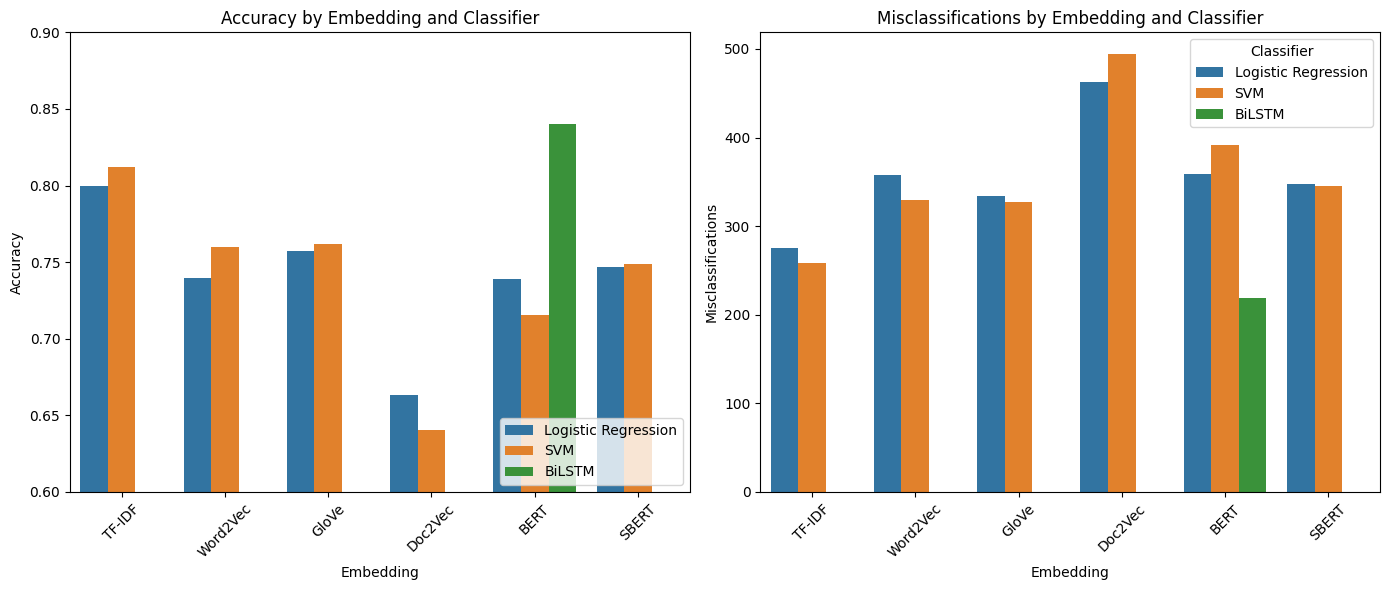

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated table data from the second image
data_v2 = {
    "Embedding": ["TF-IDF", "TF-IDF", "Word2Vec", "Word2Vec", "GloVe", "GloVe", "Doc2Vec", "Doc2Vec",
                  "BERT", "BERT", "SBERT", "SBERT", "BERT"],
    "Classifier": ["Logistic Regression", "SVM", "Logistic Regression", "SVM", "Logistic Regression", "SVM",
                   "Logistic Regression", "SVM", "Logistic Regression", "SVM", "Logistic Regression", "SVM", "BiLSTM"],
    "Accuracy": [0.800, 0.812, 0.7396, 0.760, 0.7571, 0.7621, 0.6632, 0.6407,
                 0.7389, 0.7156, 0.7469, 0.7490, 0.8401],
    "Misclassifications": [275, 258, 358, 330, 334, 327, 463, 494,
                           359, 391, 348, 345, 219]
}

# Create DataFrame
df_v2 = pd.DataFrame(data_v2)

# Set figure size
plt.figure(figsize=(14, 6))

# Accuracy Barplot
plt.subplot(1, 2, 1)
sns.barplot(data=df_v2, x="Embedding", y="Accuracy", hue="Classifier")
plt.title("Accuracy by Embedding and Classifier")
plt.xticks(rotation=45)
plt.ylim(0.6, 0.9)
plt.legend(loc='lower right')

# Misclassifications Barplot
plt.subplot(1, 2, 2)
sns.barplot(data=df_v2, x="Embedding", y="Misclassifications", hue="Classifier")
plt.title("Misclassifications by Embedding and Classifier")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
